# 3 | Pre-session B | Exploring metamerism
**ES143 Computer Vision, Harvard University, Fall 2020**

Name: **Wisoo Song**

---
This is an independent coding assignment. Upon completion you will:
* be able to numerically compute colors from spectra using discrete approximations to integrals
* be able to convert between linear and non-linear color spaces
* describe the concepts of perceptual difference and metamerism

Instructions:
* Follow the instructions below to write code and create a graph.
* Summarize your conclusions from this graph in the final cell of the notebook (Discussion).
* Submit your `.ipynb` and `.html` files to the [assignment page](https://canvas.harvard.edu/courses/78234/assignments/407968). Filenames should be of the form `metamers_lastname_firstname.ipynb` and `metamers_lastname_firstname.html`. 

---
Two distinct spectral distributions are metameric if they induce the same responses in the cones of a human retina. Said another way, metamers are distinct spectral distributions that map to the same tristimulus vector (in CIE XYZ or any other linear color space). 

Suppose you own a grocery store that sells bananas. It is in your interest to choose the lighting in your store to have a spectral power distribution that makes overripe bananas appear as similar possible to bananas that are in their prime. That is, you want the
light spectra reflected from ripe and overripe bananas to be as close as possible to being metameric. 

The files `ripe.csv` and `overripe.csv` contain two spectral reflectance functions, sampled in 10nm increments from 400nm to 700nm, of bananas that have been in a grocery store for five and seven days, respectively. 

Write code in the cell below to produce a graph that has on the horizontal axis the temperature ($T$) of a blackbody illuminant, and on the vertical axis the (approximate) perceptual difference between the retinal color of the ripe banana and the retinal color of an unripe banana when each is illuminated by a blackbody source with temperature $T$. The temperatures of the sources should be restricted to the range $[2500,...,10050]$K. 

The perceptual difference should be approximated using the Euclidean distance between 3-vectors in the Lab color space. Use the CIE XYZ color matching functions stored in file `ciexyz64_1.csv` to compute XYZ colors. When converting from XYZ to Lab, assume that the white point is $(X_n,Y_n,Z_n)=(1,1,1)$.

Based on your graph, what can you conlude about the illuminant temperature that is best for your grocery store?

(This question is inspired by Bill Freeman) 

---
The following cell unpacks and reads three CSV files. It requires data file `bananas.zip` (from the course website) to be in the same directory as this notebook. It provides spectral data in three variables.

* `xyz`: $4{\times}N$ array with columns: wavelength (nm), X-value, Y-value, Z-value
* `ripe`: $2{\times}N$ array with columns: wavelength (nm), reflectance value
* `overripe`: $2{\times}N$ array with columns: wavelength (nm), reflectance value


In [6]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import cv2
import os

# Extract zip file 
! unzip -n ./bananas.zip

xyz = np.loadtxt(fname = "./bananas/ciexyz64_1.csv", delimiter = ",")
ripe = np.loadtxt(fname = "./bananas/ripe.csv", delimiter = ",")
overripe = np.loadtxt(fname = "./bananas/overripe.csv", delimiter = ",")

Archive:  ./bananas.zip


[4.0e-07 4.1e-07 4.2e-07 4.3e-07 4.4e-07 4.5e-07 4.6e-07 4.7e-07 4.8e-07
 4.9e-07 5.0e-07 5.1e-07 5.2e-07 5.3e-07 5.4e-07 5.5e-07 5.6e-07 5.7e-07
 5.8e-07 5.9e-07 6.0e-07 6.1e-07 6.2e-07 6.3e-07 6.4e-07 6.5e-07 6.6e-07
 6.7e-07 6.8e-07 6.9e-07 7.0e-07]
(3, 31)
(31, 2)
(31, 2)


Text(0, 0.5, '||Lab(ripe) - Lab(overripe)||')

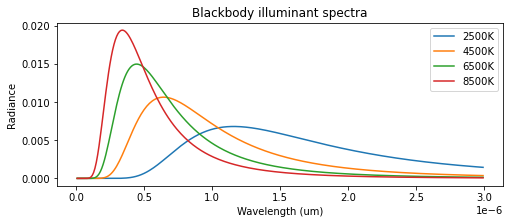

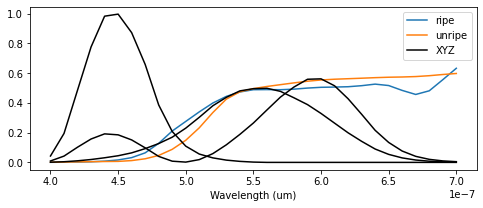

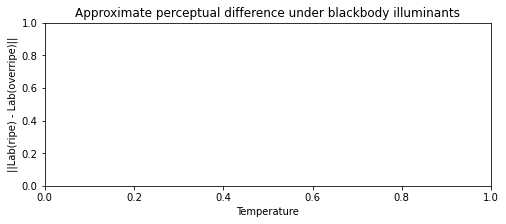

In [28]:
# Define dense set of wavelengths for approximating integrals with sums
#   - use the same wavelength sampling as in files ripe and overripe
#   - convert from nanometers to meters
int_wavelengths = ripe[:,0] * (10 ** -9)

print(int_wavelengths)


#### -------------
# Clean up the spectrum data

# for convenience, discard the first columns of ripe and overripe
ripe_spect = ripe[:,1] # single column of reflectance value
overripe_spect = overripe[:,1]

# for convenience, sub-sample the CIE XYZ functions at the integration wavelengths
XYZ = np.transpose(xyz[np.isin(xyz[:,0], ripe[:,0]),1:4]) # take all the values of xyz array wher ripe's wavelength is recorded

# 3 , 31 
print(XYZ.shape)  # each row: corresponds to X, Y , Z value / each col: corresponds to each wavelength examined

print(ripe.shape) # 31, 2
print(overripe.shape)
#### ------------- 

# Helper function: Convert XYZ to LAB (assuming white point (1,1,1))
def xyz_to_lab(xyz):
    
    XYZn = [1,1,1]
    # np.cbrt: returns cube root of an array
    fx = np.cbrt(xyz[0]/XYZn[0]) if xyz[0]/XYZn[0] > (6/29)**3 else (xyz[0]/XYZn[0])/(3*(6/29)**2) + 2*(6/29)/3
    fy = np.cbrt(xyz[1]/XYZn[1]) if xyz[1]/XYZn[1] > (6/29)**3 else (xyz[1]/XYZn[1])/(3*(6/29)**2) + 2*(6/29)/3
    fz = np.cbrt(xyz[2]/XYZn[2]) if xyz[2]/XYZn[2] > (6/29)**3 else (xyz[2]/XYZn[2])/(3*(6/29)**2) + 2*(6/29)/3
    
    lab = np.zeros(np.shape(xyz))
    lab[0] = 116*fy - 16
    lab[1] = 500*(fx - fy)
    lab[2] = 200*(fy - fz)
    
    return lab

# Helper function: Spectrum of blackbody source with color temperature T, 
#   computed at wavelengths provided, and normalized so that the summed radiant power 
#   over wavelengths is 1
def blackbody(T, wavelengths):

    spd = wavelengths**(-5)/(np.exp(0.014388/(t*wavelengths)) - 1)
    spd = spd/np.sum(spd)

    return spd

# warm-up: visualization of some blackbody spectra over visible and non-visible wavelengths
fig1,ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Radiance')
ax1.set_title('Blackbody illuminant spectra')
manywavelengths = np.arange(10,3000,10,dtype='float64') * (10 ** -9)

XYZ_many = np.transpose(xyz[np.isin(xyz[:,0], manywavelengths),1:4]) # take all the values of xyz array wher ripe's wavelength is recorded



for i, t in enumerate(np.arange(2500, 10050, 2000)):
    ax1.plot(manywavelengths,blackbody(t,manywavelengths), label = '%dK' % t)
ax1.legend()

# warm-up: visualization of the banana spectra and XYZ matching functions
fig2,ax1 = plt.subplots(figsize=(8,3))
ax1.set_xlabel('Wavelength (um)')
# ax1.set_ylabel("Radiance") # SN
ax1.plot(int_wavelengths, ripe_spect, label = 'ripe')
ax1.plot(int_wavelengths, overripe_spect, label = 'unripe')
ax1.plot(int_wavelengths, XYZ[0,]/2,'k')
ax1.plot(int_wavelengths, XYZ[1,]/2,'k')
ax1.plot(int_wavelengths, XYZ[2,]/2,'k',label = 'XYZ')
ax1.legend()

# this is the graph that you are supposed to complete
fig3,ax1 = plt.subplots(figsize=(8,3))
ax1.set_title('Approximate perceptual difference under blackbody illuminants')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('||Lab(ripe) - Lab(overripe)||')

# TO DO: write your code here to complete in the graph
# ax1.plot(int_wave)



# Given temperature, what is the XYZ of ripe?
# == Given temperature, calculate Lab of ripe at every wavelength

In [29]:
from scipy import interpolate




ripe_spect_dense = interpolate.interp1d(ripe_spect, manywavelengths)




ValueError: x and y arrays must be equal in length along interpolation axis.

In [25]:
# wavelength ==> XYZ
T = np.arange(2500, 10050, 2000)

# What is the optimal X, Y, Z that gives us minimal Lab (ripe) - Lab(overripe) ? 

# For every T in the range:
for t in T:
    #  For every wavelength,
    
    radiances = blackbody(t, int_wavelengths) # This gives us radiance at each wavelength in int_wavelengths
    ripe_l = radiances * ripe_spect
    overripe_l = radiances * overripe_spect
    
    xyz_ripe = ripe_spect_dense(ripe_l)
    print(xyz_ripe)
    
    
    
#     Lab_diff = 
    #print(radiances)
    # (31,)
#     print(ripe_spect.shape)
#     print(radiances)
#     print((radiances *ripe_spect).shape)
    
    # use ciexyz.csv to convert wavelength to xyz
    #get the radiance at T & wavelength
    # radiance * Lab(XYZ of (radiance at temp T*ripe reflectance value) - Lab(XYZ of overripe)
    



ValueError: A value in x_new is below the interpolation range.

In [ ]:
# for every XYZ of wavelengths in ripe,
    #

### Discussion

_Provide a one-paragraph summary of your conclusions_